In [1]:
# Common imports

from qiskit import QuantumCircuit, transpile
from qiskit.circuit import Gate
from qiskit_aer import Aer
from qiskit.visualization import plot_distribution

In [2]:
# Common tools

from math import sqrt

def run_simulation(qc: QuantumCircuit, shots: int = 2000):
    # Running given QuantumCircuit on a simulator
    backend_sim = Aer.get_backend('qasm_simulator')
    job_sim = backend_sim.run(transpile(qc, backend_sim), shots=shots)
    return job_sim.result().get_counts()

def optimal_iterations(input_qubits: int) -> int:
    return round(sqrt(2 ** (input_qubits - 1)))

def generate_password(input_qubits):
    # Generates a sequence of '0's and '1's of length given by input_qubits
    return ''.join(random.choices("01", k=input_qubits))

def validate_password(password):
    # A valid password is not empty and contains only '0' and '1' chars
    # Returns: password length
    if (len(password) == 0):
        raise ValueError(f'Wrong password length: {len(password)}')
    if (any(c not in "01" for c in password)):
        raise ValueError(f'Wrong password contains chars other than 0 and 1')
    return len(password)

def reverse(s: str) -> str:
    # String reverse
    return s[::-1]

In [3]:
import random

def StaticPredicateGate(password: str) -> Gate:
    # Creates gate working as a predicate statically configured with given password.
    # The number of qubits required by the gate equals password length plus one ancilla qubit.
    # The ancilla qubit must be set to '0' at input.
    # The gate sets the ancilla qubit to '1' for the input equal to password and '0' for all other inputs.
    return StaticPredicateQC(password).to_gate()

def StaticPredicateQC(password: str) -> QuantumCircuit:
    input_qubits = validate_password(password)
    all_qubits = input_qubits + 1
    ancilla_qubit = all_qubits - 1
    classical_bits = 0
    
    qc = QuantumCircuit(all_qubits, classical_bits, name='StaticPredicate')
    password_to_gates(qc, password)
    qc.mcx(list(range(input_qubits)), ancilla_qubit)
    password_to_gates(qc, password)
    return qc

def password_to_gates(qc, password):
    # Putting XGate (negation) for every '0' char and IGate (identity) for every '1' char
    # Note: adding identity gate is optional
    for i, k in enumerate(reverse(password)):
        qc.x(i) if k == '0' else qc.id(i)

In [4]:
# Example: Generating a random search password for use in all following examples
# Note: you need only change it here to update all examples
# Note: when using input_qubits > 10 you should disable drawing the circuit CompleteCircuitWithOptimalIterationsQC down below

input_qubits = 3
password = generate_password(input_qubits)

print(f"Example password is '{password}'")
print(f"Number of all qubits is {input_qubits} input qubits plus 1 ancilla qubit")
print(f"Optimal number of quantum search iterations is {optimal_iterations(input_qubits)}")

Example password is '011'
Number of all qubits is 3 input qubits plus 1 ancilla qubit
Optimal number of quantum search iterations is 2


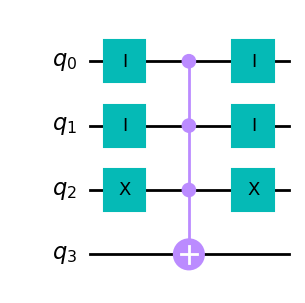

In [5]:
# Example: internal structure of a StaticPredicate gate

qc = StaticPredicateQC(password)
qc.draw("mpl", style="clifford")

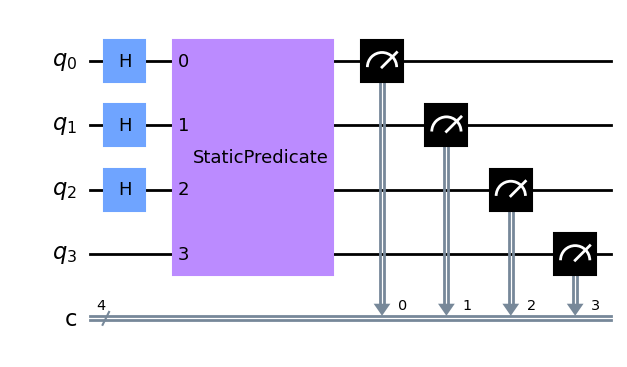

In [6]:
# Example: a result measured for the gate alone
# Note: all input and output combinations have equal probability
# Note: the function result is represented as value 0 or 1 in the last (ancilla) qubit

def StaticPredicateAloneQC(password: str) -> QuantumCircuit:
    input_qubits = validate_password(password)
    all_qubits = input_qubits + 1
    classical_bits = all_qubits
    
    pr = StaticPredicateGate(password)
    qc = QuantumCircuit(all_qubits, classical_bits)
    for i in range(input_qubits):
        qc.h(i)
    qc.append(pr, range(all_qubits))
    qc.measure(range(all_qubits), range(classical_bits))
    return qc

qc = StaticPredicateAloneQC(password)
qc.draw("mpl", style="clifford")

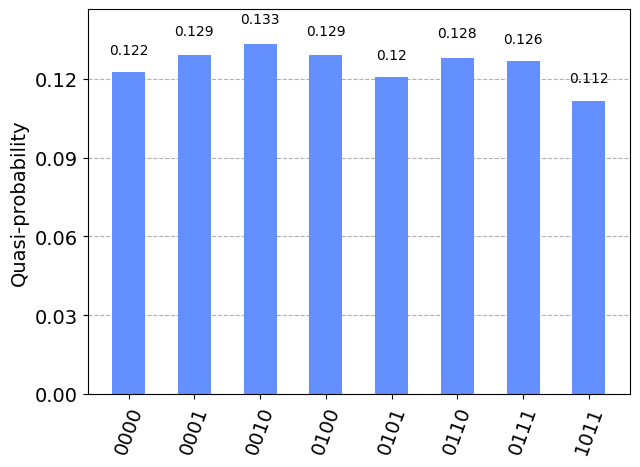

In [7]:
plot_distribution(run_simulation(qc))

In [8]:
def StubFunctionGate(password: str) -> Gate:
    # Creates gate working as a predicate statically configured with given password.
    # The number of qubits required by the gate equals password length plus one ancilla qubit. 
    # The gate switches phase for the input equal to password and leaves it unchanged for all other inputs.
    # The ancilla qubit must be set to '0' at input.
    # The ancilla qubit is untangled and always set to '0' at output.
    return StubFunctionQC(password).to_gate()

def StubFunctionQC(password: str) -> QuantumCircuit:
    input_qubits = validate_password(password)
    all_qubits = input_qubits + 1
    ancilla_qubit = all_qubits - 1
    classical_bits = 0
    
    pr = StaticPredicateGate(password)
    qc = QuantumCircuit(all_qubits, 0, name='StubFunction')
    qc.append(pr, range(all_qubits))
    qc.z(ancilla_qubit)
    qc.append(pr.inverse(), range(all_qubits))
    return qc

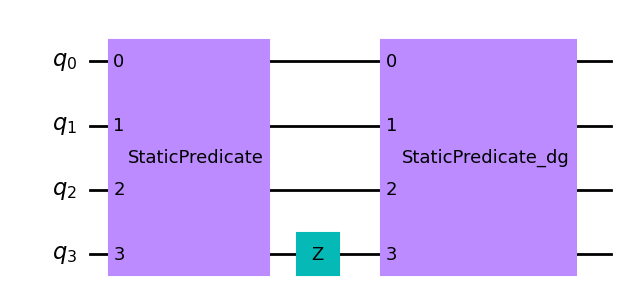

In [9]:
# Example: internal structure of a StubFunction gate
# Note: "_dg" suffix means an inverse

qc = StubFunctionQC(password)
qc.draw("mpl", style="clifford")

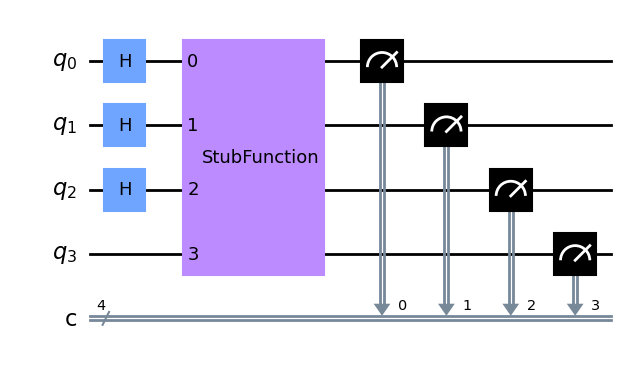

In [10]:
# Example: a result measured for the StubFunction gate alone
# Note: all combinations have equal probability; 
# Note: The function result is represented as phase alone (the value of last (ancilla) qubit is always 0.
#       Without any further action the information about phase gets lost in measurement.

def StubFunctionAloneQC(password: str) -> QuantumCircuit:
    input_qubits = validate_password(password)
    all_qubits = input_qubits + 1
    classical_bits = all_qubits

    fn = StubFunctionGate(password)
    qc = QuantumCircuit(all_qubits, classical_bits)
    for i in range(input_qubits):
        qc.h(i)
    qc.append(fn, range(all_qubits))
    qc.measure(range(all_qubits), range(classical_bits))
    return qc

qc = StubFunctionAloneQC(password)
qc.draw("mpl", style="clifford")

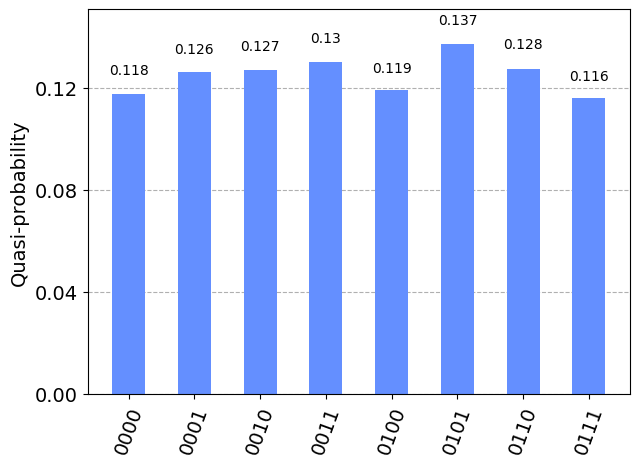

In [11]:
plot_distribution(run_simulation(qc))

In [12]:
def AmplifierGate(input_qubits: int) -> Gate:
    # Creates gate implementing amplifying probabilities of inputs marked with phase switched.
    # The number of qubits required by the gate equals password length plus one ancilla qubit.
    # The ancilla qubit must be set to '0' at input.
    # The ancilla qubit is untangled and always set to '0' at output.
    # The phase of marked inputs gets switched back in the process. 
    return AmplifierQC(input_qubits).to_gate()

def AmplifierQC(input_qubits: int) -> QuantumCircuit:
    all_qubits = input_qubits + 1
    ancilla_qubit = all_qubits - 1
    classical_bits = 0

    qc = QuantumCircuit(all_qubits, classical_bits, name='Amplifier')
    for i in range(input_qubits):
        qc.h(i)
    for i in range(input_qubits):
        qc.x(i)

    qc.mcx(list(range(input_qubits)), ancilla_qubit)
    qc.z(ancilla_qubit)
    qc.mcx(list(range(input_qubits)), ancilla_qubit)

    for i in range(input_qubits):
        qc.x(i)
    for i in range(input_qubits):
        qc.h(i)
    return qc

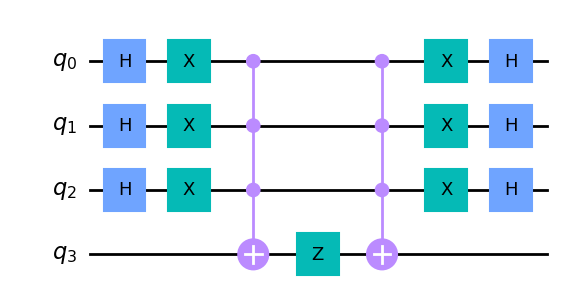

In [13]:
# Example: internal structure of an Amplifier gate

qc = AmplifierQC(input_qubits)
qc.draw('mpl', style="clifford")

In [14]:
def SearchIterationQC(password: str) -> QuantumCircuit:
    # Creates gate implementing single iteration of the Search Algorithm.
    # The number of qubits required by the gate equals password length plus one ancilla qubit.
    # The ancilla qubit must be set to '0' at input.
    # The ancilla qubit is untangled and always set to '0' at output.
    input_qubits = validate_password(password)
    all_qubits = input_qubits + 1
    classical_bits = 0
    
    fn = StubFunctionGate(password)
    am = AmplifierGate(input_qubits)
    qc = QuantumCircuit(all_qubits, classical_bits, name='SearchIteration')
    qc.append(fn, range(all_qubits))
    qc.append(am, range(all_qubits))
    return qc

def SearchIterationGate(password: str) -> Gate:
    return SearchIterationQC(password).to_gate()

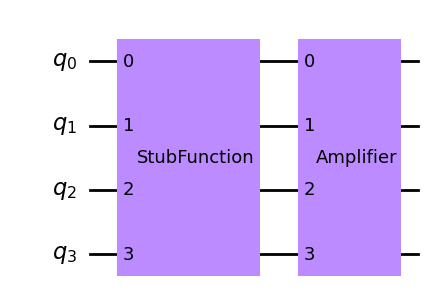

In [15]:
# Example: internal structure of single iteration

qc = SearchIterationQC(password)
qc.draw('mpl', style="clifford")

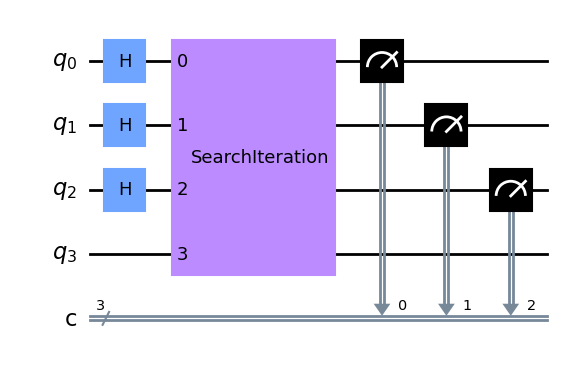

In [16]:
# Example: complete circuit with one iteration

def CompleteCircuitWithOneSearchIterationQC(password: str) -> QuantumCircuit:
    input_qubits = validate_password(password)
    all_qubits = input_qubits + 1
    classical_bits = input_qubits

    it = SearchIterationGate(password)
    qc = QuantumCircuit(all_qubits, classical_bits)
    for i in range(input_qubits):
        qc.h(i)
    qc.append(it, range(all_qubits))
    qc.measure(range(input_qubits), range(classical_bits))
    return qc

qc = CompleteCircuitWithOneSearchIterationQC(password)
qc.draw("mpl", style="clifford")

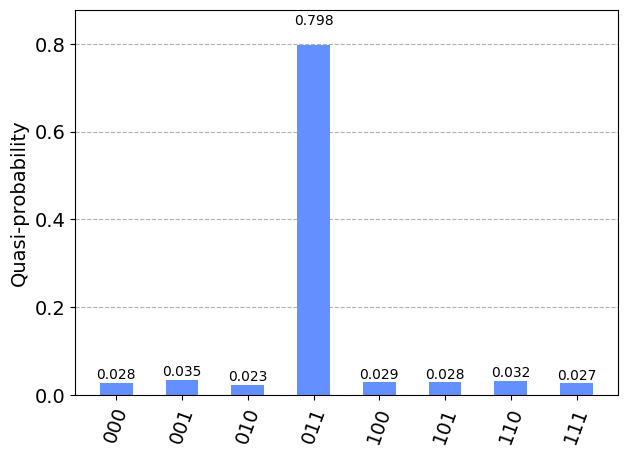

In [17]:
plot_distribution(run_simulation(qc))

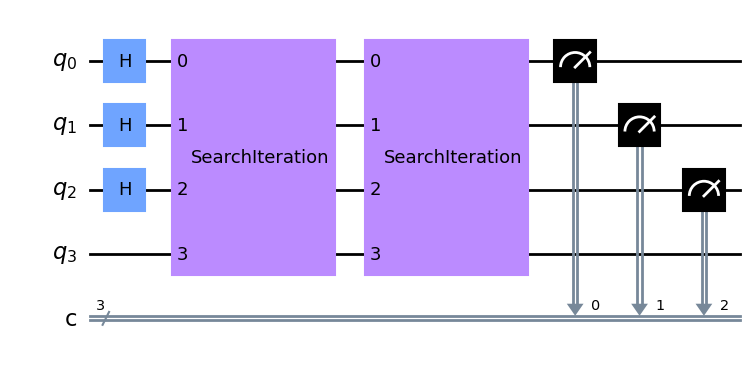

In [18]:
from math import sqrt

# Example: complete circuit with two iterations

def CompleteCircuitWithOptimalSearchIterationsQC(password: str) -> QuantumCircuit:
    input_qubits = validate_password(password)
    all_qubits = input_qubits + 1
    classical_bits = input_qubits

    it = SearchIterationGate(password)
    qc = QuantumCircuit(all_qubits, classical_bits)
    for i in range(input_qubits):
        qc.h(i)

    for j in range(optimal_iterations(input_qubits)):
        qc.append(it, range(all_qubits))

    qc.measure(range(input_qubits), range(classical_bits))
    return qc

qc = CompleteCircuitWithOptimalSearchIterationsQC(password)
qc.draw("mpl", style="clifford")

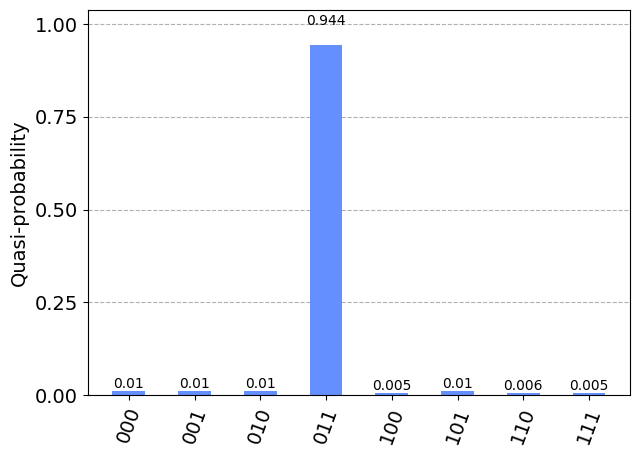

In [19]:
plot_distribution(run_simulation(qc))